In [1]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


### Loading FBI NIBRS data 

#### The clean_nibrs_df function in this notebook should be able to do the preliminary data cleaning on all of the Federal NIBRS datasets found here [https://ucr.fbi.gov/nibrs/2018/tables/data-tables#federal-table](https://ucr.fbi.gov/nibrs/2018/tables/data-tables#federal-table). Simply change the year in the URL to get the corresponding table. 

In [64]:
# Load 2019 FBI NIBRS data

df_nibrs_19 = pd.read_excel('data/nibrs/United_States_Offense_Type_by_Agency_2019.xls', skiprows=[0,1,2])

df_nibrs_19.head()

,State,Agency Type,Agency Name,Population1,Total\nOffenses,Crimes\nAgainst\nPersons,Crimes\nAgainst\nProperty,Crimes\nAgainst\nSociety,Crimes Against Persons,Unnamed: 9,...,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Assault\nOffenses,Aggravated\nAssault,...,Betting/\nWagering,Operating/\nPromoting/\nAssisting\nGambling,Gambling\nEquipment\nViolations,Sports\nTampering,Por-\nnography/\nObscene\nMaterial,Pros-\ntitution\nOffenses,Pros-\ntitution,Assisting or\nPromoting\nProstitution,Purchasing\nProstitution,Weapon\nLaw\nViolations
1,ALABAMA,Cities,Hoover,85670.0,4293.0,840.0,2801.0,652.0,811,68,...,0,0,0,0,2,1,1,0,0,67
2,ARIZONA,Cities,Apache Junction2,42531.0,NaN,430.0,NaN,487.0,383,71,...,0,0,0,0,6,0,0,0,0,36
3,NaN,NaN,Coolidge,13138.0,1155.0,230.0,684.0,241.0,214,61,...,0,0,0,0,1,0,0,0,0,18
4,NaN,NaN,Eagar,4897.0,102.0,36.0,29.0,37.0,21,7,...,0,0,0,0,0,0,0,0,0,1


In [75]:
def clean_nibrs_df(df, year):

    # Get missing column names
    names = df.iloc[0].tolist()
    missing_names = names[8:]
    # missing_names = [name.replace('\n', ' ').replace(' ', '_').replace('/_', '/').replace('-_', '').replace('__', '_') for name in missing_names]

    #Get column names and replace UnNamed columns with the corresponding name
    column_names = df.columns.to_list()
    column_names = column_names[:8]
    for name in missing_names:
        column_names.append(name)

    #Clean the column names up
    column_names = [name.replace('\n', ' ').replace(' ', '_').replace('/_', '/').replace('-_', '').replace('__', '_') for name in column_names]
    df.columns = column_names
    df = df.drop(df.index[0])
    
    # Replace NaN values in 'State' with the first non-NaN value using ffill
    df['State'] = df['State'].fillna(method='ffill')
    
    # Make sure just the first letter is capitalized
    df['State'] = df['State'].str.capitalize()

    # Replace NaN values in 'Agency_Type' with the first non-NaN value using ffill
    df['Agency_Type'] = df['Agency_Type'].fillna(method='ffill')
    
    #filter to the city level
    df = df[df["Agency_Type"]=="Cities"]
    
    df["Year"] = year
    
    df.drop(['Agency_Type'], axis=1, inplace=True)
    
    df.rename(columns = {"Agency_Name":"City"}, inplace=True)
    
    df["State_City"] = df["State"] + ", " + df["City"]
    
    df.drop(["State", "City"], axis=1, inplace=True)
    
    df = df.groupby(["State_City"]).mean().reset_index()
    
    def calc_pct_tot(df, col_name):
        df[col_name + "_pct"] = df[col_name]/df["Population1"]
        return df

    df = calc_pct_tot(df, "Total_Offenses")
    df = calc_pct_tot(df, "Crimes_Against_Persons")
    df = calc_pct_tot(df, "Crimes_Against_Property")
    df = calc_pct_tot(df, "Crimes_Against_Society")
    
    df = df[["State_City","Population1", "Total_Offenses_pct",
             "Crimes_Against_Persons_pct", "Crimes_Against_Property_pct", 
             "Crimes_Against_Society_pct", "Year"]]
    
    df = df.dropna(axis = 0)
    
    return df

In [76]:
cleaned_df_nibrs_19 = clean_nibrs_df(df_nibrs_19, 2019)

cleaned_df_nibrs_19.head()

,State_City,Population1,Total_Offenses_pct,Crimes_Against_Persons_pct,Crimes_Against_Property_pct,Crimes_Against_Society_pct,Year
0,"Alabama, Hoover",85670.0,0.050111,0.009805,0.032695,0.007611,2019.0
2,"Arizona, Coolidge",13138.0,0.087913,0.017506,0.052063,0.018344,2019.0
3,"Arizona, Eagar",4897.0,0.020829,0.007351,0.005922,0.007556,2019.0
4,"Arizona, Gilbert",253619.0,0.041752,0.007271,0.024225,0.010256,2019.0
5,"Arizona, Huachuca City",1723.0,0.042368,0.015090,0.023796,0.003482,2019.0


In [77]:
print(cleaned_df_nibrs_19.shape)

(4143, 7)


In [78]:
cleaned_df_nibrs_19.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4143 entries, 0 to 4167
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   State_City                   4143 non-null   object 
 1   Population1                  4143 non-null   float64
 2   Total_Offenses_pct           4143 non-null   float64
 3   Crimes_Against_Persons_pct   4143 non-null   float64
 4   Crimes_Against_Property_pct  4143 non-null   float64
 5   Crimes_Against_Society_pct   4143 non-null   float64
 6   Year                         4143 non-null   float64
dtypes: float64(6), object(1)
memory usage: 258.9+ KB


### Loading and preprocessing the HPSA dataset.

In [11]:
import time, os, math, numpy as np, pandas as pd, sklearn as sk, matplotlib as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [12]:
# Load dataset for all Primary Care HPSA destinations with one record per facility
df_hpsa_pc = pd.read_csv("data/hpsa/BCD_HPSA_FCT_DET_PC.csv")

In [13]:
# q = """SELECT * 
#        FROM df_hpsa_pc
#        LIMIT 10;"""

# pysqldf(q)

In [14]:
print("Unique HPSA IDs: " + str(df_hpsa_pc['HPSA ID'].nunique()))
print("Unique Zip Codes: " + str(df_hpsa_pc["Common Postal Code"].nunique()))
print("Unique Cities: " + str(df_hpsa_pc["HPSA City"].nunique()))
print("Unique Counties " + str(df_hpsa_pc["Common County Name"].nunique()))

Unique HPSA IDs: 15939
Unique Zip Codes: 4557
Unique Cities: 3319
Unique Counties 3210


In [15]:
df_hpsa_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66858 entries, 0 to 66857
Data columns (total 66 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   HPSA Name                                                                 66858 non-null  object 
 1   HPSA ID                                                                   66858 non-null  object 
 2   Designation Type                                                          66858 non-null  object 
 3   HPSA Discipline Class                                                     66858 non-null  object 
 4   HPSA Score                                                                66858 non-null  int64  
 5   PC MCTA Score                                                             21358 non-null  float64
 6   Primary State Abbreviation                                    

In [16]:
df_hpsa_pc['Designation Type'].value_counts()

Designation Type
HPSA Population                                                                31873
Geographic HPSA                                                                23350
High Needs Geographic HPSA                                                      4366
Rural Health Clinic                                                             2970
Federally Qualified Health Center                                               1579
Indian Health Service, Tribal Health, and Urban Indian Health Organizations     1181
Correctional Facility                                                            991
Federally Qualified Health Center Look A Like                                    296
Other Facility                                                                   252
Name: count, dtype: int64

In [17]:
df_hpsa_pc.nunique().reset_index().sort_values(by=0, ascending=False).head(20)

,index,0
36,HPSA Component Name,38080
11,HPSA Geography Identification Number,36085
1,HPSA ID,15939
0,HPSA Name,14177
15,HPSA Designation Population,11432
37,HPSA Component Source Identification Number,7269
43,HPSA Estimated Underserved Population,6617
21,Latitude,6421
20,Longitude,6420
34,HPSA Address,6147


In [18]:
locations = df_hpsa_pc[["Common County Name","HPSA Geography Identification Number", 'HPSA City', 'HPSA Component Name', 'HPSA Component Source Identification Number']]
locations.head()

,Common County Name,HPSA Geography Identification Number,HPSA City,HPSA Component Name,HPSA Component Source Identification Number
0,"Lucas County, OH",39095004800,NaN,"Census Tract 48, Lucas County, Ohio",NaN
1,"Lucas County, OH",39095004600,NaN,"Census Tract 46, Lucas County, Ohio",NaN
2,"Lucas County, OH",39095004701,NaN,"Census Tract 47.01, Lucas County, Ohio",NaN
3,"Noble County, OH",POINT,Caldwell,Noble Correctional Institution,1396293612
4,"Williams County, OH",POINT,Edgerton,EDGERTON FAMILY HEALTH CENTER,1396199989


In [19]:
df_hpsa_pc["HPSA City"].value_counts()

HPSA City
Los Angeles      44
Chicago          37
Anchorage        32
New York         29
Houston          25
                 ..
House Springs     1
Berne             1
North Vernon      1
Flora             1
Seminole          1
Name: count, Length: 3319, dtype: int64

In [20]:
df_hpsa_pc_cities = df_hpsa_pc[df_hpsa_pc["HPSA City"].isna()==False]
df_hpsa_pc_cities["State_City"] = df_hpsa_pc_cities["State Name"] + ", " + df_hpsa_pc_cities["HPSA City"]

In [21]:
df_hpsa_pc_cities['HPSA Designation Year'] = df_hpsa_pc_cities['HPSA Designation Date'].str[-4:].astype(int)
df_hpsa_pc_cities['HPSA Designation Last Update Year'] = df_hpsa_pc_cities['HPSA Designation Last Update Date'].str[-4:].astype(int)

# filter to the relevant years
# df_hpsa_pc_cities = df_hpsa_pc_cities[(df_hpsa_pc_cities['HPSA Designation Last Update Year'] >= 2019) & (df_hpsa_pc_cities['HPSA Designation Year'] <= 2016)]

In [22]:
df_hpsa_select = df_hpsa_pc_cities[["State_City", 'Designation Type', 'HPSA Score', 'PC MCTA Score',
                                    'U.S. - Mexico Border 100 Kilometer Indicator'
                                   ]]
df_hpsa_select.head()

,State_City,Designation Type,HPSA Score,PC MCTA Score,U.S. - Mexico Border 100 Kilometer Indicator
3,"Ohio, Caldwell",Correctional Facility,6,0.0,N
4,"Ohio, Edgerton",Rural Health Clinic,14,15.0,N
17,"Ohio, London",Correctional Facility,6,0.0,N
18,"Ohio, Grafton",Correctional Facility,3,0.0,N
19,"Ohio, Saint Clairsville",Correctional Facility,6,0.0,N


In [23]:
df_hpsa_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6924 entries, 3 to 66854
Data columns (total 5 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   State_City                                    6924 non-null   object 
 1   Designation Type                              6924 non-null   object 
 2   HPSA Score                                    6924 non-null   int64  
 3   PC MCTA Score                                 4627 non-null   float64
 4   U.S. - Mexico Border 100 Kilometer Indicator  6924 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 324.6+ KB


In [24]:
df_hpsa_select['U.S. - Mexico Border 100 Kilometer Indicator'].value_counts()

U.S. - Mexico Border 100 Kilometer Indicator
N    6803
Y     117
U       4
Name: count, dtype: int64

In [25]:
df_hpsa_select['U.S. - Mexico Border 100 Kilometer Indicator'] = df_hpsa_select['U.S. - Mexico Border 100 Kilometer Indicator'].replace({'N': 0, 'U': 0, 'Y': 1})

In [26]:
# replace null values in the PC MCTA Score column with 0 to represent no shortage.
df_hpsa_select.fillna(0, inplace=True)

In [27]:
df_hpsa_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6924 entries, 3 to 66854
Data columns (total 5 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   State_City                                    6924 non-null   object 
 1   Designation Type                              6924 non-null   object 
 2   HPSA Score                                    6924 non-null   int64  
 3   PC MCTA Score                                 6924 non-null   float64
 4   U.S. - Mexico Border 100 Kilometer Indicator  6924 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 324.6+ KB


In [28]:
df_mean_score = df_hpsa_select.groupby(["State_City"])[["HPSA Score", "PC MCTA Score", "U.S. - Mexico Border 100 Kilometer Indicator"]].mean().reset_index()
df_mean_score.rename(columns={"HPSA Score": "HPSA_Score_Ave", "PC MCTA Score": "MCTA_Score_Ave", "U.S. - Mexico Border 100 Kilometer Indicator": "Mex_Border_Ave"}, inplace=True)
df_mean_score

,State_City,HPSA_Score_Ave,MCTA_Score_Ave,Mex_Border_Ave
0,"Alabama, Albertville",8.500000,0.000000,0.0
1,"Alabama, Aliceville",21.000000,9.000000,0.0
2,"Alabama, Athens",0.000000,0.000000,0.0
3,"Alabama, Atmore",13.333333,5.333333,0.0
4,"Alabama, Bayou La Batre",18.000000,0.000000,0.0
...,...,...,...,...
4009,"Wyoming, Riverton",16.666667,5.666667,0.0
4010,"Wyoming, Rock Springs",11.000000,0.000000,0.0
4011,"Wyoming, Sundance",16.000000,13.000000,0.0
4012,"Wyoming, Thermopolis",8.000000,9.000000,0.0


In [29]:
df_count_hpsa = df_hpsa_select.groupby(["State_City"])[["HPSA Score", "PC MCTA Score", "U.S. - Mexico Border 100 Kilometer Indicator"]].count().reset_index()
df_count_hpsa.rename(columns={"HPSA Score": "HPSA_Score_Count", "PC MCTA Score": "MCTA_Score_Count", "U.S. - Mexico Border 100 Kilometer Indicator": "Mex_Border_Count"}, inplace=True)
df_count_hpsa

,State_City,HPSA_Score_Count,MCTA_Score_Count,Mex_Border_Count
0,"Alabama, Albertville",2,2,2
1,"Alabama, Aliceville",1,1,1
2,"Alabama, Athens",1,1,1
3,"Alabama, Atmore",3,3,3
4,"Alabama, Bayou La Batre",1,1,1
...,...,...,...,...
4009,"Wyoming, Riverton",3,3,3
4010,"Wyoming, Rock Springs",1,1,1
4011,"Wyoming, Sundance",1,1,1
4012,"Wyoming, Thermopolis",1,1,1


In [30]:
df_hpsa_summary = df_count_hpsa.merge(df_mean_score, on= "State_City")
df_hpsa_summary

,State_City,HPSA_Score_Count,MCTA_Score_Count,Mex_Border_Count,HPSA_Score_Ave,MCTA_Score_Ave,Mex_Border_Ave
0,"Alabama, Albertville",2,2,2,8.500000,0.000000,0.0
1,"Alabama, Aliceville",1,1,1,21.000000,9.000000,0.0
2,"Alabama, Athens",1,1,1,0.000000,0.000000,0.0
3,"Alabama, Atmore",3,3,3,13.333333,5.333333,0.0
4,"Alabama, Bayou La Batre",1,1,1,18.000000,0.000000,0.0
...,...,...,...,...,...,...,...
4009,"Wyoming, Riverton",3,3,3,16.666667,5.666667,0.0
4010,"Wyoming, Rock Springs",1,1,1,11.000000,0.000000,0.0
4011,"Wyoming, Sundance",1,1,1,16.000000,13.000000,0.0
4012,"Wyoming, Thermopolis",1,1,1,8.000000,9.000000,0.0


## Joining NIBRS and HPSA

In [31]:
nibrs_select.head()

,State,City,Year,Population1,Total_Offenses_pct,Crimes_Against_Persons_pct,Crimes_Against_Property_pct,Crimes_Against_Society_pct
0,Alabama,Hoover,2019.0,85670.0,0.050111,0.009805,0.032695,0.007611
2,Arizona,Coolidge,2019.0,13138.0,0.087913,0.017506,0.052063,0.018344
3,Arizona,Eagar,2019.0,4897.0,0.020829,0.007351,0.005922,0.007556
4,Arizona,Gilbert,2019.0,253619.0,0.041752,0.007271,0.024225,0.010256
5,Arizona,Huachuca City,2019.0,1723.0,0.042368,0.015090,0.023796,0.003482


In [32]:
nibrs_select["State_City"] = nibrs_select["State"] + ", " + nibrs_select["City"]
nibrs_select.columns

Index(['State', 'City', 'Year', 'Population1', 'Total_Offenses_pct',
       'Crimes_Against_Persons_pct', 'Crimes_Against_Property_pct',
       'Crimes_Against_Society_pct', 'State_City'],
      dtype='object')

In [33]:
nibrs_select_2019 = nibrs_select[['State_City', 'Population1', 'Total_Offenses_pct',
       'Crimes_Against_Persons_pct', 'Crimes_Against_Property_pct',
       'Crimes_Against_Society_pct']]

In [34]:
nibrs_select_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4143 entries, 0 to 4167
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   State_City                   4143 non-null   object 
 1   Population1                  4143 non-null   float64
 2   Total_Offenses_pct           4143 non-null   float64
 3   Crimes_Against_Persons_pct   4143 non-null   float64
 4   Crimes_Against_Property_pct  4143 non-null   float64
 5   Crimes_Against_Society_pct   4143 non-null   float64
dtypes: float64(5), object(1)
memory usage: 226.6+ KB


In [53]:
nibrs_hpsa = nibrs_select_2019.merge(df_hpsa_summary, how="inner", on="State_City")
nibrs_hpsa

,State_City,Population1,Total_Offenses_pct,Crimes_Against_Persons_pct,Crimes_Against_Property_pct,Crimes_Against_Society_pct,HPSA_Score_Count,MCTA_Score_Count,Mex_Border_Count,HPSA_Score_Ave,MCTA_Score_Ave,Mex_Border_Ave
0,"Arizona, Gilbert",253619.0,0.041752,0.007271,0.024225,0.010256,1,1,1,18.0,13.00,0.0
1,"Arizona, Somerton",16771.0,0.015324,0.004174,0.009242,0.001908,4,4,4,16.0,9.75,1.0
2,"Arizona, Yuma",98769.0,0.071247,0.011238,0.046320,0.013689,1,1,1,0.0,0.00,1.0
3,"Arkansas, Ash Flat",1095.0,0.078539,0.017352,0.047489,0.013699,1,1,1,15.0,20.00,0.0
4,"Arkansas, Augusta",1939.0,0.061372,0.019598,0.035585,0.006189,1,1,1,15.0,19.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
878,"Wisconsin, Sturtevant",6645.0,0.019413,0.002859,0.008427,0.008126,1,1,1,6.0,0.00,0.0
879,"Wisconsin, Waupun",11315.0,0.028635,0.002828,0.010959,0.014848,2,2,2,7.5,0.00,0.0
880,"Wisconsin, Wausau",38507.0,0.063313,0.013374,0.026151,0.023788,1,1,1,10.0,19.00,0.0
881,"Wisconsin, Whitewater",14997.0,0.044409,0.006735,0.019737,0.017937,1,1,1,15.0,11.00,0.0


In [54]:
nibrs_hpsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   State_City                   883 non-null    object 
 1   Population1                  883 non-null    float64
 2   Total_Offenses_pct           883 non-null    float64
 3   Crimes_Against_Persons_pct   883 non-null    float64
 4   Crimes_Against_Property_pct  883 non-null    float64
 5   Crimes_Against_Society_pct   883 non-null    float64
 6   HPSA_Score_Count             883 non-null    int64  
 7   MCTA_Score_Count             883 non-null    int64  
 8   Mex_Border_Count             883 non-null    int64  
 9   HPSA_Score_Ave               883 non-null    float64
 10  MCTA_Score_Ave               883 non-null    float64
 11  Mex_Border_Ave               883 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 82.9+ KB


In [55]:
nibrs_hpsa.fillna(0, inplace=True)

In [56]:
nibrs_hpsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   State_City                   883 non-null    object 
 1   Population1                  883 non-null    float64
 2   Total_Offenses_pct           883 non-null    float64
 3   Crimes_Against_Persons_pct   883 non-null    float64
 4   Crimes_Against_Property_pct  883 non-null    float64
 5   Crimes_Against_Society_pct   883 non-null    float64
 6   HPSA_Score_Count             883 non-null    int64  
 7   MCTA_Score_Count             883 non-null    int64  
 8   Mex_Border_Count             883 non-null    int64  
 9   HPSA_Score_Ave               883 non-null    float64
 10  MCTA_Score_Ave               883 non-null    float64
 11  Mex_Border_Ave               883 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 82.9+ KB


<AxesSubplot:>

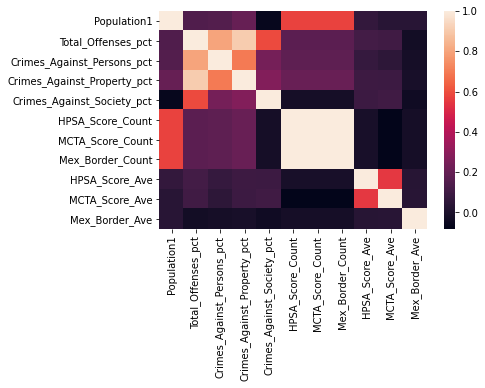

In [57]:
import numpy as np
numeric_columns = nibrs_hpsa.select_dtypes(include=[np.number])

# Calculate correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

sns.heatmap(correlation_matrix)

In [58]:
correlation_matrix

,Population1,Total_Offenses_pct,Crimes_Against_Persons_pct,Crimes_Against_Property_pct,Crimes_Against_Society_pct,HPSA_Score_Count,MCTA_Score_Count,Mex_Border_Count,HPSA_Score_Ave,MCTA_Score_Ave,Mex_Border_Ave
Population1,1.000000,0.147770,0.153005,0.204732,-0.060342,0.575434,0.575434,0.575434,0.063581,0.037923,0.035895
Total_Offenses_pct,0.147770,1.000000,0.802446,0.910916,0.593972,0.174228,0.174228,0.174228,0.112109,0.105467,-0.026633
Crimes_Against_Persons_pct,0.153005,0.802446,1.000000,0.699382,0.240689,0.182108,0.182108,0.182108,0.073730,0.046951,-0.020859
Crimes_Against_Property_pct,0.204732,0.910916,0.699382,1.000000,0.275304,0.210349,0.210349,0.210349,0.095662,0.089644,-0.011709
Crimes_Against_Society_pct,-0.060342,0.593972,0.240689,0.275304,1.000000,-0.019389,-0.019389,-0.019389,0.090869,0.104338,-0.037729
HPSA_Score_Count,0.575434,0.174228,0.182108,0.210349,-0.019389,1.000000,1.000000,1.000000,-0.010508,-0.080028,-0.019817
MCTA_Score_Count,0.575434,0.174228,0.182108,0.210349,-0.019389,1.000000,1.000000,1.000000,-0.010508,-0.080028,-0.019817
Mex_Border_Count,0.575434,0.174228,0.182108,0.210349,-0.019389,1.000000,1.000000,1.000000,-0.010508,-0.080028,-0.019817
HPSA_Score_Ave,0.063581,0.112109,0.073730,0.095662,0.090869,-0.010508,-0.010508,-0.010508,1.000000,0.549737,0.032971
MCTA_Score_Ave,0.037923,0.105467,0.046951,0.089644,0.104338,-0.080028,-0.080028,-0.080028,0.549737,1.000000,0.035538


## Arcos

In [41]:
# df_arcos = pd.read_csv('data/arcos/arcos_all_washpost.tsv', delimiter='\t', nrows=50000000)

In [42]:
# !pip install arcospy
import arcospy

In [43]:
MN_pharm = arcospy.total_pharmacies_state(state='MN')
MN_pharm.head()
# MN_county_pop = arcospy.county_population(state="MN", key="WaPo")
# MN_county_pop.tail()
# MN_county_pop.year.value_counts()
# MN_county_pop_avg = MN_county_pop.groupby('BUYER_COUNTY').mean().reset_index()
# MN_county_pop_avg.head()
# MN_merge = pd.merge(MN_pharm, MN_county_pop_avg, left_on='buyer_county', right_on='BUYER_COUNTY')
# MN_merge.head()

Please supply a valid API key.


,error
0,Authentication required. Did you include an AP...


In [44]:
MN_county_pop = arcospy.county_population(state="MN", key="WaPo")
MN_county_pop.tail()
MN_county_pop.year.value_counts()

year
2006    87
2007    87
2008    87
2009    87
2010    87
2011    87
2012    87
2013    87
2014    87
Name: count, dtype: int64

In [45]:
df_arcos.info()

NameError: name 'df_arcos' is not defined

In [ ]:
df_arcos["TRANSACTION_DATE"].value_counts()

In [ ]:
# df_hpsa_pc_cities['HPSA Designation Last Update Year'] = df_hpsa_pc_cities['HPSA Designation Last Update Date'].str[-4:].astype(int)
df_arcos['Transaction_Year'] = df_arcos['TRANSACTION_DATE'].str[:4].astype(int)

In [ ]:
df_arcos['Transaction_Year'].value_counts()

In [ ]:
df_arcos_2018 = df_arcos[df_arcos['Transaction_Year']==2018]

In [ ]:
df_arcos_2018.columns

In [ ]:
df_arcos_2018 = df_arcos_2018[['BUYER_CITY', 'BUYER_STATE', 'DRUG_CODE', 'NDC_NO',
       'DRUG_NAME', 'Measure', 'MME_Conversion_Factor', 'Dosage_Strength',
       'TRANSACTION_DATE', 'Combined_Labeler_Name', 'Reporter_family',
       'CALC_BASE_WT_IN_GM', 'DOSAGE_UNIT', 'MME', 'Transaction_Year']]
df_arcos_2018.head()

In [ ]:
df_arcos_2018['BUYER_STATE'].value_counts()